<a href="https://colab.research.google.com/github/krystaldowling/MAST30034_Final_Project-/blob/CNN_Model/Standard%2BGridSearch_CNN_GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This document contains code modified from https://realpython.com/python-keras-text-classification/. 

In [1]:
# Import statements
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
# Loading in preproccessed data
PATH = "/content/drive/My Drive/Data/"
data = pd.read_csv(PATH + "preproccessed_data.csv", lineterminator='\n')

data

,title,text,label
0,muslims busted stole millions gov ’ benefits,print pay back money plus interest entire fami...,1
1,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1
2,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1
3,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1
4,fantastic trumps 7 point plan reform healthcar...,email healthcare reform make america great sin...,1
...,...,...,...
29449,process analytical instruments market – techna...,technavio published new report global process ...,0
29450,travel deals get 1200 air credit two apt cookt...,apt offering savings new cape york outback wil...,0
29451,taiwanese recyclers belief waste simply mispla...,taipei taiwan sept 8 2015 prnewswire recent ye...,0
29452,season curtain raiser ideal way honour john,blackburn sunday league john haydock memorial ...,0


In [3]:
# Performing test-train split
text_train, text_test, y_train, y_test = train_test_split(data['text'].values, data['label'].values, test_size=0.25, random_state=1000)

In [4]:
# calculate the maximum document length
def max_length(lines):
	return max([len(s.split()) for s in lines])
 
maxlen = max_length(data['text'])

In [5]:
# Tokenizing data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(text_train)

X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

# Vocab size- adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1  

In [6]:
# Padding sequences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [7]:
EMBEDDING_FILE = '/content/drive/My Drive/Data/glove.6B.100d.txt'

def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (vocab_size, embed_size))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector;

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [8]:
# Function to print plot of accuracy and loss of training and test data
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [9]:
embedding_dim = 100

# Create Model
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, weights=[embedding_matrix],trainable=False))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2202, 100)         19272700  
_________________________________________________________________
conv1d (Conv1D)              (None, 2198, 128)         64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 19,338,129
Trainable params: 65,429
Non-trainable params: 19,272,700
_________________________________________________________________


In [10]:
# Fitting model
history = model.fit(X_train, y_train, epochs = 50, validation_data=(X_test, y_test), batch_size=16)


Epoch 1/50
1381/1381 [==============================] - 14s 10ms/step - loss: 0.3808 - accuracy: 0.8322 - val_loss: 0.3762 - val_accuracy: 0.8231
Epoch 2/50
1381/1381 [==============================] - 14s 10ms/step - loss: 0.2773 - accuracy: 0.8871 - val_loss: 0.4642 - val_accuracy: 0.8000
Epoch 3/50
1381/1381 [==============================] - 14s 10ms/step - loss: 0.2093 - accuracy: 0.9166 - val_loss: 0.3247 - val_accuracy: 0.8696
Epoch 4/50
1381/1381 [==============================] - 14s 10ms/step - loss: 0.1497 - accuracy: 0.9416 - val_loss: 0.3318 - val_accuracy: 0.8779
Epoch 5/50
1381/1381 [==============================] - 14s 10ms/step - loss: 0.1031 - accuracy: 0.9610 - val_loss: 0.4391 - val_accuracy: 0.8464
Epoch 6/50
1381/1381 [==============================] - 14s 10ms/step - loss: 0.0722 - accuracy: 0.9734 - val_loss: 0.4453 - val_accuracy: 0.8710
Epoch 7/50
1381/1381 [==============================] - 14s 10ms/step - loss: 0.0630 - accuracy: 0.9768 - val_loss: 0.4997 -

In [11]:
# Using code modified from https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

pred = model.predict(X_test, verbose = 0)
pred = np.rint(pred)

# Evaluate model on training data
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print('Train Accuracy: %f' % (accuracy*100))
 
# Evaluate model on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print('Test Accuracy: %f' % (accuracy*100))

# Precision Score
precision = precision_score(y_test, pred)
print('Test Precision: %f' % (precision*100))

# Recall Score
recall = recall_score(y_test, pred)
print('Test Recall: %f' % (recall*100))

# F1 Score
f1 = f1_score(y_test, pred)
print('Test F1 score: %f' % (f1*100))

Train Accuracy: 99.886829
Test Accuracy: 86.474741
Test Precision: 83.110164
Test Recall: 86.097100
Test F1 score: 84.577269


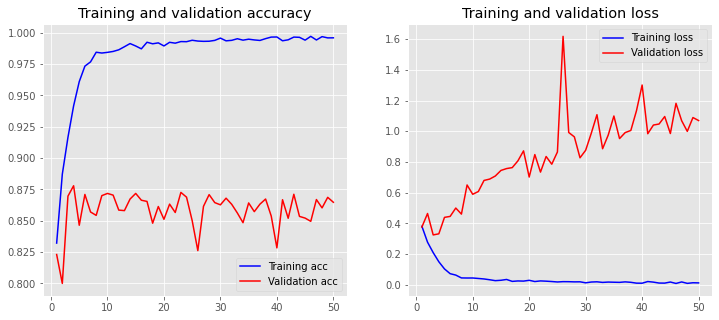

In [12]:
# Plot graphs of test/training accuracy and loss
plot_history(history)

In [13]:
# Creating model
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, weights=[embedding_matrix],trainable=False))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(6, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [14]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size= [vocab_size], 
                  embedding_dim=[100],
                  maxlen= [maxlen])


In [15]:
# Run grid search on data
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=16)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=4, verbose=1, n_iter=5)
# Fitting Model
grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)
print(test_accuracy)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
1036/1036 [==============================] - 6s 6ms/step - loss: 0.4637 - accuracy: 0.7689
Epoch 2/10
1036/1036 [==============================] - 6s 6ms/step - loss: 0.3236 - accuracy: 0.8677
Epoch 3/10
1036/1036 [==============================] - 6s 6ms/step - loss: 0.2597 - accuracy: 0.8996
Epoch 4/10
1036/1036 [==============================] - 6s 6ms/step - loss: 0.2090 - accuracy: 0.9214
Epoch 5/10
1036/1036 [==============================] - 6s 6ms/step - loss: 0.1666 - accuracy: 0.9418
Epoch 6/10
1036/1036 [==============================] - 6s 6ms/step - loss: 0.1310 - accuracy: 0.9553
Epoch 7/10
1036/1036 [==============================] - 6s 6ms/step - loss: 0.1086 - accuracy: 0.9617
Epoch 8/10
1036/1036 [==============================] - 6s 6ms/step - loss: 0.0846 - accuracy: 0.9702
Epoch 9/10
1036/1036 [==============================] - 6s 6ms/step - loss: 0.0771 - accuracy: 0.9703
Epoch 10/10
346/346 [==============================] - 2s 5ms/step - loss: 0.5599 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 23.1min finished


Epoch 1/10
1381/1381 [==============================] - 10s 7ms/step - loss: 0.3812 - accuracy: 0.8382
Epoch 2/10
1381/1381 [==============================] - 10s 7ms/step - loss: 0.2799 - accuracy: 0.8907
Epoch 3/10
1381/1381 [==============================] - 10s 7ms/step - loss: 0.2306 - accuracy: 0.9098
Epoch 4/10
1381/1381 [==============================] - 10s 7ms/step - loss: 0.1788 - accuracy: 0.9321
Epoch 5/10
1381/1381 [==============================] - 10s 7ms/step - loss: 0.1350 - accuracy: 0.9511
Epoch 6/10
1381/1381 [==============================] - 10s 7ms/step - loss: 0.0949 - accuracy: 0.9670
Epoch 7/10
1381/1381 [==============================] - 10s 7ms/step - loss: 0.0697 - accuracy: 0.9769
Epoch 8/10
1381/1381 [==============================] - 10s 7ms/step - loss: 0.0545 - accuracy: 0.9820
Epoch 9/10
1381/1381 [==============================] - 10s 7ms/step - loss: 0.0482 - accuracy: 0.9842
Epoch 10/10
461/461 [==============================] - 2s 5ms/step - loss

In [16]:
# Save and evaluate results
s = ('Running data set\nBest Accuracy : {:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
output_string = s.format( grid_result.best_score_, grid_result.best_params_, test_accuracy)
print(output_string)
       

Running data set
Best Accuracy : 0.8678
{'vocab_size': 192727, 'num_filters': 128, 'maxlen': 2202, 'kernel_size': 3, 'embedding_dim': 100}
Test Accuracy : 0.8744




In [17]:
# Using code modified from https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

pred = grid.predict(X_test)
pred = np.rint(pred)

# Precision Score
precision = precision_score(y_test, pred)
print('Test Precision: %f' % (precision*100))

# Recall Score
recall = recall_score(y_test, pred)
print('Test Recall: %f' % (recall*100))

# F1 Score
f1 = f1_score(y_test, pred)
print('Test F1 score: %f' % (f1*100))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Test Precision: 85.906040
Test Recall: 84.741488
Test F1 score: 85.319791
